 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"></ul></div>

In [1]:
import glob
#import cartopy
import datetime
import scipy.io
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap, cm

import xarray as xr

% matplotlib inline

In [2]:
from dateutil.relativedelta import relativedelta
from scipy.interpolate import griddata

In [3]:
from ArcticTools import map

In [4]:
#bathy=nc.Dataset(
#    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=nc.Dataset(
    '../ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]

In [11]:
def regrid(input_x, input_y, input_data, output_x, output_y, method='nearest'):
    points=(input_x.flatten(), input_y.flatten())
    values = input_data.flatten()
    data_interp = griddata(points, values, (output_x, output_y), method=method)
    return data_interp

In [5]:
#nc_name=glob.glob('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc')
ptrc = nc.Dataset(
        '../crop.nc')
nav_lon=ptrc.variables['nav_lon'][400:,:]
nav_lat=ptrc.variables['nav_lat'][400:,:]
print(ptrc.variables.keys())
deptht= ptrc.variables['gdept_0'][0,:]
print (deptht.shape)
tmask = ptrc.variables['tmask'][0,:,400:,:]
deltat = ptrc.variables['e3t_0'][:]
umask = ptrc.variables['umask'][0, :, 400:]
vmask = ptrc.variables['vmask'][0, :, 400:]

odict_keys(['nav_lon', 'nav_lat', 'nav_lev', 'time_counter', 'tmask', 'umask', 'vmask', 'fmask', 'tmaskutil', 'umaskutil', 'vmaskutil', 'fmaskutil', 'glamt', 'glamu', 'glamv', 'glamf', 'gphit', 'gphiu', 'gphiv', 'gphif', 'e1t', 'e1u', 'e1v', 'e1f', 'e2t', 'e2u', 'e2v', 'e2f', 'ff', 'mbathy', 'e3t', 'e3u', 'e3v', 'e3w', 'gdept', 'gdepu', 'gdepv', 'gdepw', 'gdept_0', 'gdepw_0', 'e3t_0', 'e3w_0'])
(50,)


In [9]:
#rotation = nc.Dataset('/ocean/xiaoxiny/research/result_jasper/RotatedAngle_ANHA4.nc')
rotation = nc.Dataset('RotatedAngle_ANHA4.nc')
gsint = rotation.variables['gsint'][400:,:]
gcost = rotation.variables['gcost'][400:,:]

In [13]:
ocean_x = np.linspace(-180, 180,140)
ocean_y = np.linspace(69, 90, 140)
ocean_lon, ocean_lat = np.meshgrid(ocean_x, ocean_y)

In [6]:
from matplotlib.patches import Polygon
def maponCB(ax, width =1.8e6, height =1.85e6, lon_0=-145, lat_0=76.5) :
    

    lon=nav_lon
    lat=nav_lat

    m = Basemap(width=width,height=height,lon_0=lon_0, lat_0=lat_0, projection='stere', 
                resolution='i',ax=ax)
    m.fillcontinents(color='#8b7765')
    phs = np.arange(75.2, 82.3, 0.05)
    m.plot(-174.5*np.ones_like(phs), phs, latlon=True, color="k")
    phs = np.arange(79.1, 82, 0.05)
    m.plot(-115*np.ones_like(phs), phs, latlon=True, color="k")
    x_lon,y_lat=m(lon,lat)
    cmap=plt.cm.Blues
    cmap.set_bad(color='bisque')
    colours = m.pcolormesh(x_lon, y_lat, tt[31], vmin=0.2, cmap=cmap)
    cbar = m.colorbar(colours)
    cbar.ax.tick_params(labelsize=14);
    cbar.set_label(label="Total $^{230}$Th (dpm m$^{-3}$)", size=14)
    
    m.contour(x_lon,y_lat,bathy,linewidth=0.075,colors='black', levels=[3000])

    m.ax = ax

    return m,ax,x_lon,y_lat

In [7]:
tracerfile = nc.Dataset('../average_EXH005_Th.nc')
tr8 = tracerfile.variables['TR_8'][0, :]
tr10 = tracerfile.variables['TR_10'][0, :]
tt = tr8 + tr10
tt = np.ma.array(tt, mask=1-tmask, fill_value=0)

In [14]:
layer = 31
print (deptht[layer])
tempu = np.empty((400, 544))
tempv = np.empty_like(tempu)
u = np.empty((400, 544))
v = np.empty_like(u)


#    u_vel = vel('U', year)
#    v_vel = vel('V', year)
with xr.open_dataset('../average_EXH005_U.nc') as uvel:
    u_vel = uvel.variables['vozocrtx'][0,layer,400:,:]
    u_vel = np.ma.array(u_vel, mask=1-umask[layer], fill_value=0)
with xr.open_dataset('../average_EXH005_V.nc') as vvel:
        v_vel = vvel.variables['vomecrty'][0,layer,400:,:]
        v_vel = np.ma.array(v_vel, mask=1-umask[layer], fill_value=0)
print (u_vel.shape)
tempu[:, 1:] = 0.5*(u_vel[:, :-1] + u_vel[:, 1:])
tempv[1:, :] = 0.5*(v_vel[:-1, :] + v_vel[1:, :])
print (tempu.shape, tempv.shape)

u = tempu[:,:]
v = tempv[:,:]
u[tmask[layer,...] ==0] = np.nan
v[tmask[layer,...] ==0] = np.nan
u[u > 0.03] = np.nan
v[v > 0.03] = np.nan

u_mean = u
v_mean = v

U_mean = u_mean*gcost - v_mean*gsint
V_mean = v_mean*gcost + u_mean*gsint

u_mean=U_mean
v_mean=V_mean

u_regrid  = np.nan_to_num(
    regrid(nav_lon, nav_lat, u_mean, ocean_lon, ocean_lat,method='nearest'))
v_regrid  = np.nan_to_num(
    regrid(nav_lon, nav_lat, v_mean, ocean_lon, ocean_lat,method='nearest'))

541.08890874
(400, 544)
(400, 544) (400, 544)


/Users/sallen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in greater
/Users/sallen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in greater


/Users/sallen/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/sallen/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/sallen/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/sallen/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/sallen/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarnin

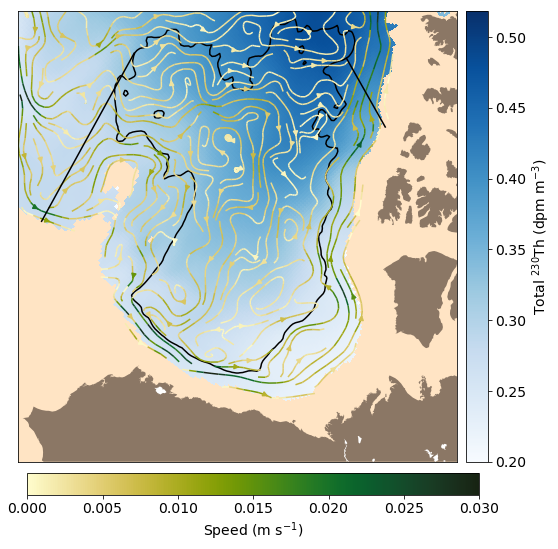

In [15]:
import matplotlib.cm as colormap
import cmocean.cm as cm

deepmask = np.load('deep.npy')
shallowmask = np.load('shallow.npy')
fig, ax = plt.subplots(1, figsize=(9, 10))
m, ax, x_lon, y_lat = maponCB(ax)
uproj, vproj = m.rotate_vector(u_regrid, v_regrid, ocean_lon, ocean_lat, returnxy=False)
uproj_rec, x, y = m.transform_scalar(uproj, ocean_x, ocean_y, 150, 150, returnxy=True)
vproj_rec, _, _ = m.transform_scalar(vproj, ocean_x, ocean_y, 150, 150, returnxy=True)

speed = np.sqrt(uproj_rec**2 + vproj_rec**2)
norm = colormap.colors.Normalize(vmax=0.03, vmin=0)

colours = m.streamplot(x, y, uproj_rec, vproj_rec, density=2, color=speed, cmap=cm.speed, 
             norm=norm) ;

cbar = fig.colorbar(colours.lines, ax=ax, orientation='horizontal', shrink=0.90, pad=0.02);
cbar.ax.tick_params(labelsize=14);
cbar.set_label(label="Speed (m s$^{-1}$)", size=14)
fig.savefig('meanflow_blue_25.pdf')